### CNN 2nd Version
- using images with annotation

In [36]:
import pandas as pd
import numpy as np
import random
import os

# tf and keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder
import keras_tuner as kt

# sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# plots
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [57]:
with open("../data/processed/processed_sub_dataset.pkl", "rb") as f:
    data = pickle.load(f)
print(data.keys())

# load data for 10 subclasses
X_train = data['X_train_sub_bbox'] 
y_train = data['y_train_sub_bbox']
X_val = data['X_val_sub_bbox']
y_val = data['y_val_sub_bbox']
# X_test = data['X_test_sub']
# y_test = data['y_test_sub']

# Only keep three classes - 'maltese_dog', 'sussex_spaniel', 'kerry_blue_terrier'
breed = ['maltese_dog', 'sussex_spaniel', 'kerry_blue_terrier']
train_mask = np.isin(y_train, breed)
val_mask = np.isin(y_val, breed)
num_breeds = len(breed)

# Filter data
X_train = X_train[train_mask]
y_train = y_train[train_mask]

X_val = X_val[val_mask]
y_val = y_val[val_mask]

# breed = data['classes_sub_bbox']
breed_ids = [i for i in range(len(breed))]
breed_id_map = {breed[i]:i for i in range(len(breed))}
id_breed_map = {id: label for label, id in breed_id_map.items()}
y_train = np.array([breed_id_map[x] for x in y_train])
y_val = np.array([breed_id_map[x] for x in y_val])
# y_test = np.array([breed_id_map[x] for x in y_test])

print(breed)

dict_keys(['X_train_sub_bbox', 'y_train_sub_bbox', 'X_val_sub_bbox', 'y_val_sub_bbox', 'classes_sub_bbox'])
['maltese_dog', 'sussex_spaniel', 'kerry_blue_terrier']


In [50]:
# Check size
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
unique_elements, counts = np.unique(y_train, return_counts=True)
print(f"Check class balance: {counts}")

X_train shape: (300, 64, 64, 3)
X_val shape: (141, 64, 64, 3)
Check class balance: [100 100 100]


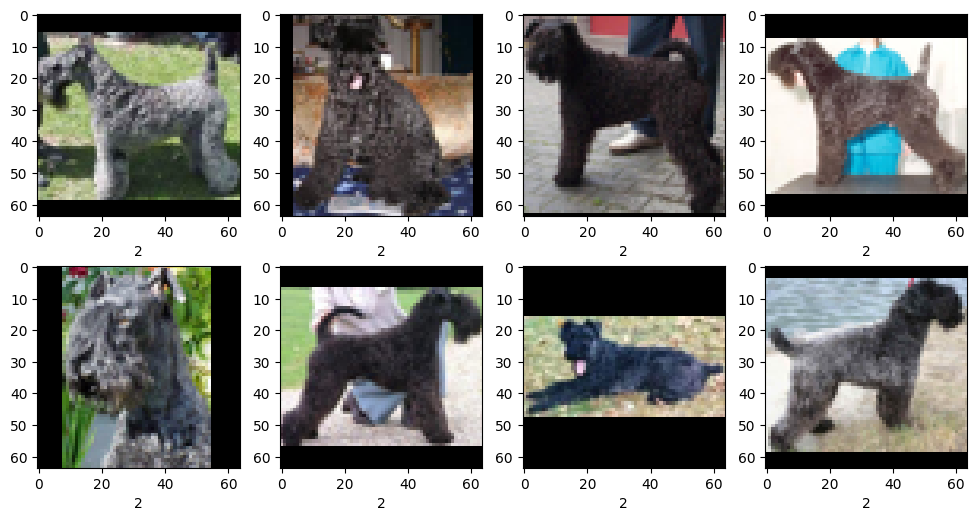

In [58]:
cols = 4
ind = [i for i, val in enumerate(y_train) if val == breed_id_map['kerry_blue_terrier']]
plt.figure(figsize=(cols * 3, 6)) 
for i in range(8):
    plt.subplot(2, cols, i + 1)
    plt.grid(False)
    img = array_to_img(X_train[ind[i]])
    plt.imshow(img)
    plt.xlabel(y_train[ind[i]])
plt.show()

Transformation and augmentation
- flip left and right - Dog images are usually symmetric, so flipping is safe
- random room in - Adds robustness to zoom
- Color and Lighting - ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05)

### Use a basic CNN architecture and keras.tuner

In [59]:
def preprocess_data_part(X_train, delta=0.2):
    """ apply transformaions and augmentations
    
    Params:
    -------
    images  (np.ndarray): Images of shape (N, 64, 64, 3)
    
    Returns:
    --------
    X_train (np.ndarray): Train images of shape (N_train, 64, 64, 3)
    """
    # tf.random.set_seed(42)
    # np.random.seed(42)
    
    # image augmentation - 1. random flip
    X_train_flip = tf.image.flip_left_right(X_train) 

    # image augmentation - 2. random rotation
    rotation_layer = tf.keras.layers.RandomRotation(factor=0.5)
    X_train_rotate = rotation_layer(X_train_flip, training=True)

    # image augmentation - 3. adjusting color
    X_train_color = tf.image.random_brightness(X_train_rotate, max_delta=delta)
    X_train_color = tf.image.random_contrast(X_train_color, lower=1 - delta, upper=1 + delta)
    X_train_color = tf.image.random_saturation(X_train_color, lower=1 - delta, upper=1 + delta)

    # image augmentation - 3. crop
    X_train_resize = []
    for i in range(X_train_color.shape[0]):
        random_size = tf.random.uniform((2,), minval=48, maxval=64, dtype=tf.int32)
        X_train_resize.append([tf.image.resize(tf.image.random_crop(value=X_train_color[i], size=(random_size[0], random_size[1], X_train_color.shape[-1])), (64, 64))])

    X_aug_res = np.concatenate(X_train_resize, axis=0)

    return X_aug_res


X_augs = [X_train]
Y_augs = [y_train]
for _ in range(29):
    Xa = preprocess_data_part(X_train)
    X_augs.append(Xa)
    Y_augs.append(y_train)

# concatenate original X_train and augmented X_train_augm data
X_train_aug = np.concatenate(X_augs, axis=0)
# concatenate y_train (note the label is preserved)
y_train_aug = tf.concat(Y_augs, axis=0)

# shuffle X_train and y_train, i.e., shuffle two tensors in the same order
shuffle = tf.random.shuffle(tf.range(tf.shape(X_train_aug)[0], dtype=tf.int32))
X_train_aug = tf.gather(X_train_aug, shuffle).numpy() # transform X back to numpy array instead of tensor
y_train_aug = tf.gather(y_train_aug, shuffle).numpy() # transform y back to numpy array instead of tensor

le = LabelEncoder()
y_train_aug = le.fit_transform(y_train_aug)
y_val = le.transform(y_val)

print(X_train_aug.shape)
print(y_train_aug.shape)
print(np.unique(y_train_aug))

(9000, 64, 64, 3)
(9000,)
[0 1 2]


In [60]:
unique, counts = np.unique(y_val, return_counts=True)
print(unique, counts)
unique, counts = np.unique(y_train_aug, return_counts=True)
print(unique, counts)

[0 1 2] [76 25 40]
[0 1 2] [3000 3000 3000]


In [61]:
def model_builder_for_n_classes(num_classes = num_breeds):
    def model_builder(hp):
        # initialize model
        tf.keras.backend.clear_session()
        random.seed(42)
        tf.random.set_seed(42)
        np.random.seed(42)
        
        model = tf.keras.Sequential()

        # add convolutional layer with hyperparameters from 1st version
        model.add(tf.keras.layers.Conv2D(
            filters=16,
            kernel_size=(2, 2),
            activation='tanh',
            padding='same',
            input_shape=(64, 64, 3)
        ))
        
        model.add(tf.keras.layers.MaxPooling2D(pool_size=4))

        model.add(tf.keras.layers.Dropout(rate=0.4))

        hp_filters = hp.Int('filters', min_value=4, max_value=16, step=4)
        hp_kernel_size = hp.Int('kernel_size', min_value=2, max_value=6, step=2)
        kernel_tuple = (hp_kernel_size, hp_kernel_size)
        hp_activation = hp.Choice('activation', values=['relu', 'tanh'])

        model.add(tf.keras.layers.Conv2D(
            filters=hp_filters,
            kernel_size=kernel_tuple,
            activation=hp_activation,
            padding='same'
            # input_shape=(64, 64, 3)
        ))
        
        hp_pool = hp.Int('pool_size', min_value=2, max_value=4, step=1)
        model.add(tf.keras.layers.MaxPooling2D(pool_size=hp_pool))

        hp_dropout = hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)
        model.add(tf.keras.layers.Dropout(rate=hp_dropout))

        model.add(tf.keras.layers.Flatten())

        model.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))

        # build and compile model
        model.build(input_shape=(None, 64, 64, 3))
        hp_lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=hp_lr),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            metrics=['accuracy'])

        return model
    return model_builder

In [62]:
tuner = kt.RandomSearch(
    model_builder_for_n_classes(num_breeds),
    objective='val_loss',
    max_trials=20,
    executions_per_trial=1,
    directory='kt_dir',
    project_name='cnn_tuning',
    overwrite=True
)

tuner.search_space_summary()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1, restore_best_weights=True)

tuner.search(
    X_train_aug, y_train_aug,  # make sure this is integer encoded
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

Trial 20 Complete [00h 00m 18s]
val_loss: 0.2954264283180237

Best val_loss So Far: 0.2792521119117737
Total elapsed time: 00h 07m 33s


In [63]:
# get the hyperparamers from the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

for hp_name in best_hps.values.keys():
    print(f"{hp_name}: {best_hps.get(hp_name)}")

filters: 8
kernel_size: 2
activation: tanh
pool_size: 2
dropout: 0.2
learning_rate: 0.01


In [64]:
def plot_acc_loss(history):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    # Plot Train Loss
    axes[0].plot(history.history['loss'], label='Train Loss', color='tab:blue')
    axes[0].plot(history.history['val_loss'], label='Validation Loss', color='tab:orange')
    axes[0].set_title("Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].legend()
    axes[0].grid(True)

    # Plot Validation Loss
    axes[1].plot(history.history['accuracy'], label='Train Accuracy', color='tab:blue')
    axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', color='tab:orange')
    axes[1].set_title("Accuracy")  
    axes[1].set_xlabel("Epoch")
    axes[1].legend()
    axes[1].grid(True)

    plt.suptitle("Loss in CNN", fontsize=12)
    plt.tight_layout()
    plt.show()

/home/lyn/miniconda3/envs/dev/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Best model summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 16)     │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 8)      │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,803 (26.58 KB)

 Trainable params: 2,267 (8.86 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,536 (17.72 KB)

None


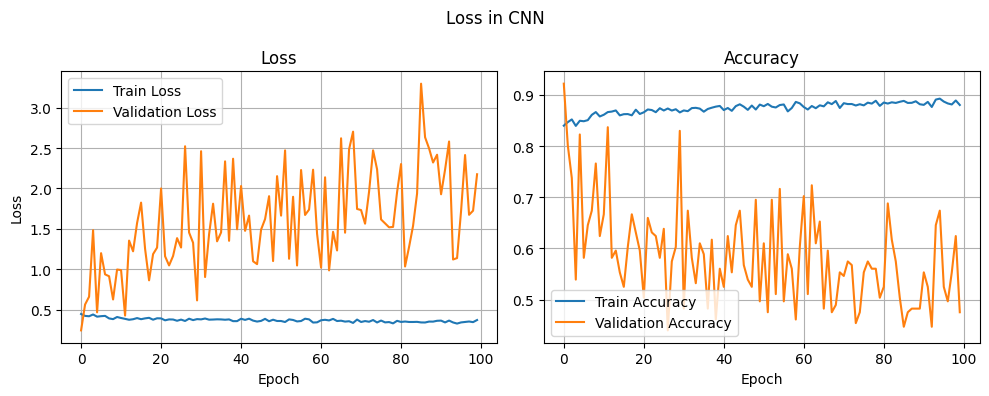

In [65]:
best_model = tuner.get_best_models(num_models=1)[0]

history_best = best_model.fit(
    X_train_aug, y_train_aug,
    validation_data=(X_val, y_val),
    epochs=100,
    verbose=0
)

print("Best model summary:")
print(best_model.summary())

plot_acc_loss(history_best)
# print(f"Train Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}")

### Use a more complex CNN architecture and tune it manually

In [ ]:
# initialize model
class ManualCNN(tf.keras.Model):
    def __init__(self, num_classes=num_breeds):
        super().__init__()

        self.preproc = tf.keras.Sequential([
                tf.keras.layers.RandomFlip("horizontal"),
                tf.keras.layers.RandomRotation(0.5),
                tf.keras.layers.RandomZoom(0.2),
                tf.keras.layers.RandomCrop(64, 64),
                tf.keras.layers.RandomBrightness(0.2, (0.0, 1.0)),
                tf.keras.layers.RandomContrast(0.2)
                # tf.keras.layers.RandomGrayscale(factor=0.5)
            ])

        self.conv1 = tf.keras.layers.Conv2D(8, (8, 8), activation='tanh', padding='same',
                                            kernel_regularizer=tf.keras.regularizers.L1L2(0.01, 0.01))
        self.pool1 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=(2, 2), padding='same')
        self.bn1 = tf.keras.layers.BatchNormalization()

        self.conv2 = tf.keras.layers.Conv2D(16, (4, 4), activation='tanh', padding='same',
                                            kernel_regularizer=tf.keras.regularizers.L1L2(0.01, 0.01))
        self.pool2 = tf.keras.layers.MaxPooling2D(pool_size=3, strides=(2, 2), padding='same')
        self.bn2 = tf.keras.layers.BatchNormalization()

        self.conv3 = tf.keras.layers.Conv2D(16, (2, 2), activation='tanh', padding='same',
                                            kernel_regularizer=tf.keras.regularizers.L1L2(0.01, 0.01))
        self.conv4 = tf.keras.layers.Conv2D(16, (2, 2), activation='tanh', padding='same',
                                            kernel_regularizer=tf.keras.regularizers.L1L2(0.01, 0.01))
        self.pool3 = tf.keras.layers.MaxPooling2D(pool_size=3, strides=(2, 2), padding='same')

        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(128, activation='tanh')
        self.fc2 = tf.keras.layers.Dense(128, activation='tanh')
        self.dropout = tf.keras.layers.Dropout(0.25)
        self.out = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, inputs, training=False):
        if training:
            x = tf.keras.layers.Lambda(lambda t: self.preproc(t, training=True))(inputs)
        else:
            x = inputs
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.bn1(x, training=training)

        x = self.conv2(x)
        x = self.pool2(x)
        x = self.bn2(x, training=training)

        x = self.conv3(x)
        x = self.conv4(x)
        x = self.pool3(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.dropout(x, training=training)
        return self.out(x)

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.4530 - loss: 5.9171 - val_accuracy: 0.6525 - val_loss: 4.1096
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.5775 - loss: 3.7255 - val_accuracy: 0.5248 - val_loss: 2.8641
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.5446 - loss: 2.5144 - val_accuracy: 0.6241 - val_loss: 2.2290
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.6162 - loss: 2.0461 - val_accuracy: 0.4184 - val_loss: 1.7894
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.6603 - loss: 1.7398 - val_accuracy: 0.2270 - val_loss: 1.9155
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.6742 - loss: 1.4408 - val_accuracy: 0.4255 - val_loss: 1.4906
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.6806 - loss: 1.2465 - val_accuracy: 0.4184 - val_loss: 2.0105
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.7035 - loss: 1.2777 - val_accuracy: 0.

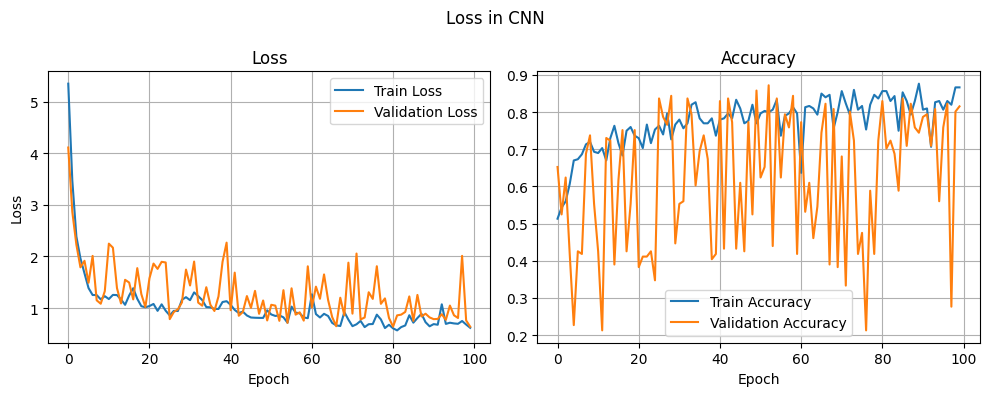

In [72]:
tf.keras.backend.clear_session()
model = ManualCNN(num_classes=num_breeds)

lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.005,
    decay_steps=1000,
    decay_rate=0.8,
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_scheduler),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=16,
    verbose=1
)

# # history = best_model.fit(
# #     X_train_aug, y_train_aug,
# #     validation_data=(X_val, y_val),
# #     epochs=50,
# #     verbose=1)

plot_acc_loss(history)

1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7d2df7013e20> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


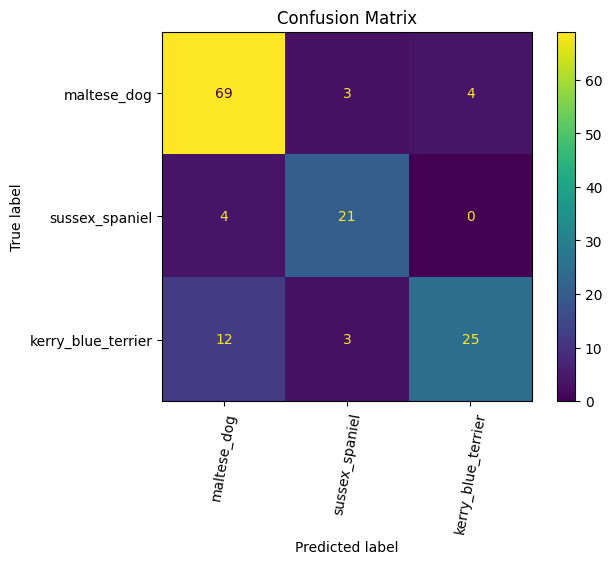

In [73]:
predicted_val = model.predict(X_val)
predicted_labels = [np.argmax(predicted_val[i]) for i in range(predicted_val.shape[0])]

# plot confusion matrix
cm = confusion_matrix(y_val, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=breed)
disp.plot()
plt.title('Confusion Matrix')
plt.xticks(rotation=80)
plt.show()

In [20]:
mistakes = cm.sum(axis=1) - np.diag(cm)
pd.DataFrame(mistakes, columns=['mistakes'], index = breed).sort_values(by=['mistakes'], ascending=False)

,mistakes
maltese_dog,45
cairn,37
ibizan_hound,27
american_staffordshire_terrier,27
english_setter,25
german_short,22
bedlington_terrier,21
flat,17
kerry_blue_terrier,16
sussex_spaniel,7
